In [1]:
# Import the libraries
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2

2025-01-01 18:19:37.917654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 18:19:37.929644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735751977.945739  334294 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735751977.949888  334294 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 18:19:37.966498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [24]:
# Set matplotlib style
plt.style.use('ggplot')

In [3]:
# List all GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 960

In [5]:
data_dir = './../task4/dataset_patched_960'

In [6]:
# HYPERPARAMETERS
BATCH_SIZE = 8
EPOCHS = 100
SEED = 42

In [7]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    # Cast inputs to float32 to avoid type mismatch
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [8]:
def dice_loss(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten the inputs
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    gamma = tf.cast(gamma, tf.float32)
    alpha = tf.cast(alpha, tf.float32)
    
    # Clip prediction values to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    
    # Calculate focal loss
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    alpha_factor = tf.ones_like(y_true, dtype=tf.float32) * alpha
    alpha_factor = tf.where(y_true == 1, alpha_factor, 1 - alpha_factor)
    
    focal_weight = alpha_factor * tf.pow(1 - pt, gamma)
    
    bce = -tf.math.log(pt)
    loss = focal_weight * bce
    
    return tf.reduce_mean(loss)
    
def weighted_bce(y_true, y_pred, pos_weight=10.0):
    """Weighted binary cross-entropy to handle class imbalance"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    
    # Calculate weighted BCE
    pos_weight = tf.constant(pos_weight, dtype=tf.float32)
    bce = -(pos_weight * y_true * tf.math.log(y_pred) + 
            (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(bce)

def precision_focused_loss(y_true, y_pred, beta=2.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    beta = tf.cast(beta, tf.float32)
    
    # Calculate true positives, false positives, and false negatives
    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate precision and recall
    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())
    
    # Calculate F-beta score
    beta_squared = beta * beta
    f_beta = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + K.epsilon())
    
    return 1 - f_beta

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-5):
    """Tversky loss with asymmetric weighting for better handling of FP and FN"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate True Positives, False Positives, and False Negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate Tversky index
    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    return 1 - tversky

def boundary_loss(y_true, y_pred, theta=1.5):
    """Boundary-aware loss to focus on root edges"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate gradients using Sobel filters
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    
    # Calculate boundary magnitude
    boundary_true = tf.sqrt(tf.square(dx_true) + tf.square(dy_true))
    boundary_pred = tf.sqrt(tf.square(dx_pred) + tf.square(dy_pred))
    
    # Calculate boundary loss
    boundary_diff = tf.abs(boundary_true - boundary_pred)
    weighted_diff = boundary_diff * tf.pow(boundary_true, theta)
    
    return tf.reduce_mean(weighted_diff)

def combined_loss(y_true, y_pred):
    """Comprehensive loss function for plant root segmentation"""
    # Cast inputs to float32 and clip predictions
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
    
    # Weight factors for each loss component
    dice_weight = tf.constant(1.0, dtype=tf.float32)
    focal_weight = tf.constant(2.5, dtype=tf.float32)
    precision_weight = tf.constant(1.5, dtype=tf.float32)
    tversky_weight = tf.constant(1.5, dtype=tf.float32)
    boundary_weight = tf.constant(0.5, dtype=tf.float32)
    
    try:
        # Calculate individual losses with error handling
        d_loss = dice_loss(y_true, y_pred, smooth=1e-5)
        f_loss = focal_loss(y_true, y_pred, gamma=3.0, alpha=0.75)
        p_loss = precision_focused_loss(y_true, y_pred, beta=0.75)
        t_loss = tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3)
        bound_loss = boundary_loss(y_true, y_pred, theta=1.5)
        
        # Check for NaN values
        losses = [d_loss, f_loss, p_loss, t_loss, bound_loss]
        for loss in losses:
            if tf.reduce_any(tf.math.is_nan(loss)):
                # If NaN detected, return a safe fallback loss
                return dice_loss(y_true, y_pred, smooth=1e-5)
        
        # Combine losses with fixed weights
        total_loss = (
            dice_weight * d_loss +
            focal_weight * f_loss +
            precision_weight * p_loss +
            tversky_weight * t_loss +
            boundary_weight * bound_loss
        )
        
        # Final NaN check
        if tf.reduce_any(tf.math.is_nan(total_loss)):
            return dice_loss(y_true, y_pred, smooth=1e-5)
            
        return total_loss
        
    except Exception as e:
        # If any error occurs, fallback to dice loss
        print(f"Error in combined loss: {e}")
        return dice_loss(y_true, y_pred, smooth=1e-5)

# Test the loss function
def test_loss_function():
    # Create test data
    y_true = tf.random.uniform((4, 64, 64, 1), 0, 2, dtype=tf.int32)
    y_pred = tf.random.uniform((4, 64, 64, 1), 0, 1, dtype=tf.float32)
    
    # Calculate loss
    loss = combined_loss(y_true, y_pred)
    print(f"Test loss value: {loss.numpy()}")
    return loss

test_loss_function()

I0000 00:00:1735751981.912385  334294 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Test loss value: 2.9394514560699463


<tf.Tensor: shape=(), dtype=float32, numpy=2.9394514560699463>

In [9]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Input layer 
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Convert grayscale to RGB and resize
    if IMG_CHANNELS == 1:
        x = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    else:
        x = inputs
    x = tf.keras.layers.Resizing(224, 224)(x)
    
    # Load MobileNet with the correct input shape
    base_model = tf.keras.applications.MobileNet(
        input_tensor=x,
        include_top=False,
        weights='imagenet'
    )
    
    # Get skip connections
    s1 = base_model.get_layer('conv_pw_1_relu').output  # 112x112
    s2 = base_model.get_layer('conv_pw_3_relu').output  # 56x56
    s3 = base_model.get_layer('conv_pw_5_relu').output  # 28x28
    s4 = base_model.get_layer('conv_pw_11_relu').output # 14x14
    
    # Bridge
    bridge = base_model.get_layer('conv_pw_13_relu').output  # 7x7
    
    # Decoder path with batch normalization and dropout
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    u6 = concatenate([u6, s4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.Dropout(0.3)(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, s3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.Dropout(0.3)(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, s2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.Dropout(0.2)(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, s1])
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.Dropout(0.1)(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Final layers with stronger activation
    outputs = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    outputs = Conv2D(32, (3, 3), activation='relu', padding='same')(outputs)
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = Conv2D(16, (3, 3), activation='relu', padding='same')(outputs)
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(outputs)

    # Add batch normalization and dropout for better training
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = tf.keras.layers.Dropout(0.3)(outputs)
    
    # Resize back to original dimensions
    final_outputs = tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH)(outputs)
    
    model = Model(inputs=inputs, outputs=final_outputs)
    model.compile(
        optimizer='adam', 
        loss=combined_loss, 
        metrics=[
            f1,
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    
    return model

In [10]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = unet_model(
    IMG_HEIGHT=patch_size,
    IMG_WIDTH=patch_size,
    IMG_CHANNELS=1
)

# Load the weight if it exists
if os.path.exists('best_model.weights.h5'):
    model.load_weights('best_model.weights.h5')

# model.summary()

/tmp/ipykernel_334294/4055785752.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
/home/FireFury/miniconda3/envs/plant2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
def z_score_normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std == 0:
        std += K.epsilon()
    return (image - mean) / std

# Image generators with rescaling
# train_image_datagen = ImageDataGenerator(rescale=1./255)
# val_image_datagen = ImageDataGenerator(rescale=1./255)
train_image_datagen = ImageDataGenerator(preprocessing_function=z_score_normalize)
val_image_datagen = ImageDataGenerator(preprocessing_function=z_score_normalize)

# Mask generators with binary conversion
def preprocess_mask(mask):
    # Convert to binary (0 or 1)
    return (mask > 0).astype('float32')

train_mask_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_mask
)

val_mask_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_mask
)

# Training image generator
train_image_generator = train_image_datagen.flow_from_directory(
    f'{data_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

# Training mask generator
train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{data_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

# Validation image generator
val_image_generator = val_image_datagen.flow_from_directory(
    f'{data_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

# Validation mask generator
val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{data_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

# Create a custom generator that yields both images and masks
def combined_generator(image_generator, mask_generator):
    while True:
        yield next(image_generator), next(mask_generator)

# Create the combined generators
train_generator = combined_generator(train_image_generator, train_mask_generator)
val_generator = combined_generator(val_image_generator, val_mask_generator)

Found 3213 images belonging to 1 classes.
Found 3213 images belonging to 1 classes.
Found 243 images belonging to 1 classes.
Found 243 images belonging to 1 classes.


In [15]:
import os

In [16]:
class VisualizePredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_image_generator, val_mask_generator, output_dir='prediction_progress'):
        super().__init__()
        # Store individual generators instead of combined generator
        self.val_image_generator = val_image_generator
        self.val_mask_generator = val_mask_generator
        self.output_dir = output_dir
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    
    def on_epoch_end(self, epoch, logs=None):
        # Get samples from individual generators
        x = next(self.val_image_generator)
        y_true = next(self.val_mask_generator)
        
        # Rest of the visualization code remains the same
        y_pred = self.model.predict(x)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        ax1.imshow(x[0, :, :, 0], cmap='gray')
        ax1.set_title('Input Image')
        ax1.axis('off')
        
        ax2.imshow(y_true[0, :, :, 0], cmap='gray')
        ax2.set_title('True Mask')
        ax2.axis('off')
        
        ax3.imshow(y_pred[0, :, :, 0], cmap='gray')
        ax3.set_title(f'Predicted Mask (Epoch {epoch+1})')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/epoch_{epoch+1:03d}.png')
        plt.close()

In [17]:
# EarlyStopping()
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [

    # EarlyStopping
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    # ModelCheckpoint
    ModelCheckpoint(filepath='./best_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min'),
    
    # VisualizePredictionCallback
    VisualizePredictionCallback(val_image_generator, val_mask_generator)
]

In [18]:
# Calculate steps per epoch
train_steps = train_image_generator.samples // BATCH_SIZE
val_steps = val_image_generator.samples // BATCH_SIZE

# Train the model with steps specified (without class_weight)
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
)

Epoch 1/100
Error in combined loss: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.
Error in combined loss: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be 

I0000 00:00:1735752001.264816  334399 service.cc:148] XLA service 0x7f1cc0001e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735752001.264860  334399 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-01 18:20:01.772011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1735752002.226604  334399 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1735752002.227818  334399 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
I0000 00:00:1735752003.464046  334399 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-01 18:20:33.643034: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Regi

401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9078 - f1: 0.2340 - loss: 0.7799 - precision: 0.0524 - recall: 0.7047Error in combined loss: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


W0000 00:00:1735752171.809926  334400 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1735752171.811762  334400 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
401/401 ━━━━━━━━━━━━━━━━━━━━ 209s 405ms/step - accuracy: 0.9080 - f1: 0.2345 - loss: 0.7794 - precision: 0.0525 - recall: 0.7046 - val_accuracy: 0.9973 - val_f1: 0.6959 - val_loss: 0.3201 - val_precision: 0.7444 - val_recall: 0.6727
Epoch 2/100


W0000 00:00:1735752196.976249  334401 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1735752196.976481  334401 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
2025-01-01 18:23:50.622136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_2', 16 bytes spill stores, 16 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/stepstep - accuracy: 0.9962 - f1: 0.6115 - loss: 0.3973 - precision: 0.6134 - recall: 0.63
401/401 ━━━━━━━━━━━━━━━━━━━━ 190s 387ms/step - accuracy: 0.9962 - f1: 0.6115 - loss: 0.3973 - precision: 0.6134 - recall: 0.6320 - val_accuracy: 0.9973 - val_f1: 0.7358 - val_loss: 0.2678 - val_precision: 0.6806 - val_recall: 0.8084
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepstep - accuracy: 0.9965 - f1: 0.6457 - loss: 0.3550 - precision: 0.6482 - recall: 0.66
401/401 ━━━━━━━━━━━━━━━━━━━━ 163s 407ms/step - accuracy: 0.9965 - f1: 0.6457 - loss: 0.3550 - precision: 0.6482 - recall: 0.6648 - val_accuracy: 0.9975 - val_f1: 0.7030 - val_loss: 0.3049 - val_precision: 0.7046 - val_recall: 0.7682
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/stepstep - accuracy: 0.9965 - f1: 0.6524 - loss: 0.3492 - precision: 0.6549 - recall: 0.67
401/401 ━━━━━━━━━━━━━━━━━━━━ 162s 405ms/step - accuracy: 0.9965 - f1: 0.6524 - loss: 0.3492 - precision: 0.6549 - recall: 0.6781 - val_

In [20]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.17170606553554535
Best validation f1: 0.8286560773849487


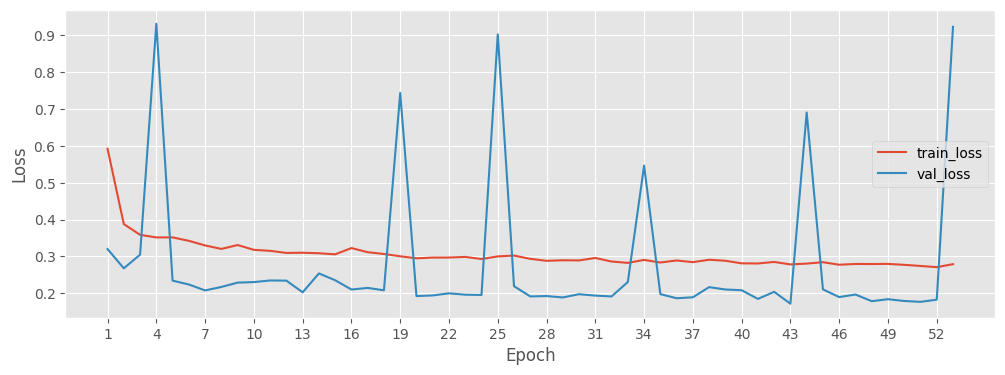

In [35]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(12, 4))
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

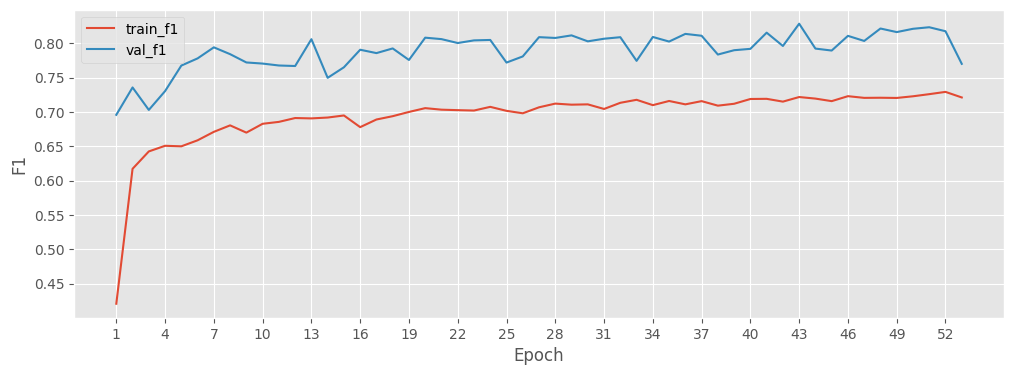

In [28]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.figure(figsize=(12, 4))
plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [23]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'soheil_6989490_unet_model_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

soheil_6989490_unet_model_960px.h5
